In [14]:
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
import random
import math
import copy
import time
from typing import List, Tuple, Dict, Any, Optional
import json
from mcts import TrucoEnvironment, TrucoStateAdapter, USE_REAL_ENV, SimplifiedTrucoState, MCTSNode, DeterminizedMCTS, ISMCTSNode, ISMCTS

In [15]:
def run_game(player1, player2, use_real_env=False):
    if use_real_env and USE_REAL_ENV:
        env = TrucoEnvironment(verbose=False)
        state = env.reset()

        move_count = 0
        while not state['game_over'] and move_count < 100:
            adapted_state = TrucoStateAdapter(state)

            if state['current_player'] == 0:
                action = player1.get_action(adapted_state, 0)
            else:
                action = player2.get_action(adapted_state, 1)

            env_action = {'type': action[0].lower(), 'data': action[1]}

            state, _, done, _ = env.step(env_action)
            move_count += 1

            if done:
                break

        if state['scores'][0] > state['scores'][1]:
            return 0
        elif state['scores'][1] > state['scores'][0]:
            return 1
        else:
            return -1
    else:
        state = SimplifiedTrucoState()
        state.deal_cards()

        move_count = 0

        while not state.is_terminal() and move_count < 50:
            if state.current_player == 0:
                action = player1.get_action(state, 0)
            else:
                action = player2.get_action(state, 1)

            state.apply_action(action)
            move_count += 1

        if state.scores[0] > state.scores[1]:
            return 0
        elif state.scores[1] > state.scores[0]:
            return 1
        else:
            return -1

In [16]:
def run_fair_tournament(games=100, use_real_env=False, simulations_per_move=500, seed=None):
    if seed is not None:
        random.seed(seed)
        np.random.seed(seed)

    det_mcts = DeterminizedMCTS(total_simulations=simulations_per_move)
    ismcts = ISMCTS(total_simulations=simulations_per_move)

    results = {
        'det_mcts_wins': 0,
        'ismcts_wins': 0,
        'draws': 0,
        'det_mcts_simulations': [],
        'ismcts_simulations': []
    }

    for i in range(games):
        print(f"Game {i + 1}/{games}", end='\r')

        det_mcts.total_simulations = 0
        ismcts.total_simulations = 0

        if i % 2 == 0:
            winner = run_game(det_mcts, ismcts, use_real_env)
            if winner == 0:
                results['det_mcts_wins'] += 1
            elif winner == 1:
                results['ismcts_wins'] += 1
            else:
                results['draws'] += 1
        else:
            winner = run_game(ismcts, det_mcts, use_real_env)
            if winner == 0:
                results['ismcts_wins'] += 1
            elif winner == 1:
                results['det_mcts_wins'] += 1
            else:
                results['draws'] += 1

        max_reasonable_sims = 5000

        det_sims = min(det_mcts.total_simulations, max_reasonable_sims)
        is_sims = min(ismcts.total_simulations, max_reasonable_sims)

        results['det_mcts_simulations'].append(det_sims)
        results['ismcts_simulations'].append(is_sims)

    return results

In [17]:
def analyze_specific_scenarios():
    det_mcts = DeterminizedMCTS(total_simulations=250)
    ismcts = ISMCTS(total_simulations=250)

    scenarios = {
        'early_game': {'det_mcts': 0, 'ismcts': 0},
        'with_truco': {'det_mcts': 0, 'ismcts': 0},
        'bluff_detection': {'det_mcts': 0, 'ismcts': 0}
    }

    for _ in range(50):
        state = SimplifiedTrucoState()
        state.deal_cards()

        weak_hand = [('4', 'copas'), ('5', 'oros'), ('6', 'bastos')]
        strong_hand = [('1', 'espadas'), ('7', 'oros'), ('3', 'copas')]

        state.hands[0] = weak_hand
        state.hands[1] = strong_hand
        state.truco_state = 'TRUCO'
        state.current_bet = 3
        state.pending_truco = True

        det_mcts_action = det_mcts.get_action(state, 0)
        ismcts_action = ismcts.get_action(state, 0)

        if det_mcts_action[0] == 'REJECT_TRUCO':
            scenarios['bluff_detection']['det_mcts'] += 1
        if ismcts_action[0] == 'REJECT_TRUCO':
            scenarios['bluff_detection']['ismcts'] += 1

    return scenarios

In [18]:
def visualize_results(results):
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    axes = axes.flatten()

    ax = axes[0]
    labels = ['Determinized\nMCTS', 'IS-MCTS', 'Draws']
    wins = [results['det_mcts_wins'], results['ismcts_wins'], results['draws']]
    colors = ['#3498db', '#e74c3c', '#95a5a6']

    bars = ax.bar(labels, wins, color=colors, alpha=0.8)
    ax.set_ylabel('Games Won')
    ax.set_title('Fair Tournament Results - Both Algorithms Use Hidden Information',
                 fontweight='bold')

    for bar, win in zip(bars, wins):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width() / 2., height + 0.5,
                f'{win}%', ha='center', va='bottom')

    ax = axes[1]
    avg_det_mcts_sims = np.mean(results.get('det_mcts_simulations', [])) if results.get('det_mcts_simulations') else 0
    avg_ismcts_sims = np.mean(results.get('ismcts_simulations', [])) if results.get('ismcts_simulations') else 0

    metrics = ['Avg Simulations', 'Win Rate %', 'Efficiency']
    det_mcts_vals = [avg_det_mcts_sims / 1000, results['det_mcts_wins'],
                     results['det_mcts_wins'] / (avg_det_mcts_sims / 1000)]
    ismcts_vals = [avg_ismcts_sims / 1000, results['ismcts_wins'],
                   results['ismcts_wins'] / (avg_ismcts_sims / 1000)]

    x = np.arange(len(metrics))
    width = 0.35

    bars1 = ax.bar(x - width / 2, det_mcts_vals, width, label='Det-MCTS', color='#3498db', alpha=0.8)
    bars2 = ax.bar(x + width / 2, ismcts_vals, width, label='IS-MCTS', color='#e74c3c', alpha=0.8)

    ax.set_ylabel('Score')
    ax.set_title('Performance Metrics', fontweight='bold')
    ax.set_xticks(x)
    ax.set_xticklabels(metrics)
    ax.legend()

    for i, (bars, vals) in enumerate([(bars1, det_mcts_vals), (bars2, ismcts_vals)]):
        for j, (bar, val) in enumerate(zip(bars, vals)):
            height = bar.get_height()
            if j == 0:
                ax.text(bar.get_x() + bar.get_width() / 2., height + 0.5,
                        f'{val:.1f}k', ha='center', va='bottom', fontsize=9)
            else:
                ax.text(bar.get_x() + bar.get_width() / 2., height + 0.5,
                        f'{val:.1f}', ha='center', va='bottom', fontsize=9)

    ax = axes[2]
    if 'det_mcts_simulations' in results and 'ismcts_simulations' in results:
        data_to_plot = [results['det_mcts_simulations'], results['ismcts_simulations']]

        bp = ax.boxplot(data_to_plot, tick_labels=['Det-MCTS', 'IS-MCTS'],
                        patch_artist=True, showmeans=True)

        colors = ['#3498db', '#e74c3c']
        for patch, color in zip(bp['boxes'], colors):
            patch.set_facecolor(color)
            patch.set_alpha(0.6)

        ax.set_ylabel('Simulations per Game')
        ax.set_title('Computational Load Distribution', fontweight='bold')
        ax.grid(True, alpha=0.3)

        for i, (data, color) in enumerate(zip(data_to_plot, colors)):
            mean_val = np.mean(data)
            ax.text(i + 1, mean_val, f'μ={mean_val:.0f}',
                    ha='center', va='bottom', fontsize=9, color=color)
    else:
        ax.text(0.5, 0.5, 'No simulation data available', ha='center', va='center')
        ax.set_title('Computational Load Distribution', fontweight='bold')

    ax = axes[3]

    det_sims = results['det_mcts_simulations']
    is_sims = results['ismcts_simulations']

    det_first_wins = sum(1 for i in range(0, 100, 2) if i < len(results['det_mcts_simulations']) and
                         ((i % 2 == 0 and results['det_mcts_wins'] > i / 2) or
                          (i % 2 == 1 and results['ismcts_wins'] <= i / 2)))

    is_first_wins = sum(1 for i in range(1, 100, 2) if i < len(results['ismcts_simulations']) and
                        ((i % 2 == 1 and results['ismcts_wins'] > i / 2) or
                         (i % 2 == 0 and results['det_mcts_wins'] <= i / 2)))

    categories = ['Avg Moves\nper Game', 'Computational\nVariability']

    det_mcts_scores = [
        np.mean(det_sims) / 500,
        np.std(det_sims) / 1000,
    ]

    ismcts_scores = [
        np.mean(is_sims) / 500,
        np.std(is_sims) / 1000,
    ]

    max_moves = max(det_mcts_scores[0], ismcts_scores[0])
    det_mcts_scores[0] = det_mcts_scores[0] / max_moves
    ismcts_scores[0] = ismcts_scores[0] / max_moves

    x = np.arange(len(categories))
    width = 0.35

    bars1 = ax.bar(x - width / 2, det_mcts_scores, width, label='Det-MCTS', color='#3498db', alpha=0.8)
    bars2 = ax.bar(x + width / 2, ismcts_scores, width, label='IS-MCTS', color='#e74c3c', alpha=0.8)

    ax.set_ylabel('Score')
    ax.set_ylim(0, 1.2)
    ax.set_title('Algorithm Behavior Characteristics', fontweight='bold')
    ax.set_xticks(x)
    ax.set_xticklabels(categories, rotation=0)
    ax.legend()

    for bars, scores in [(bars1, det_mcts_scores), (bars2, ismcts_scores)]:
        for bar, score, i in zip(bars, scores, range(len(scores))):
            height = bar.get_height()
            if i == 0:
                ax.text(bar.get_x() + bar.get_width() / 2., height + 0.02,
                        f'{score * max_moves:.1f}', ha='center', va='bottom', fontsize=9)
            elif i == 1:
                ax.text(bar.get_x() + bar.get_width() / 2., height + 0.02,
                        f'{score:.1f}k', ha='center', va='bottom', fontsize=9)
            else:
                ax.text(bar.get_x() + bar.get_width() / 2., height + 0.02,
                        f'{score:.2f}', ha='center', va='bottom', fontsize=9)

    plt.tight_layout()
    return fig

Running MCTS vs IS-MCTS tournament for Truco

Running tournament with 500 simulations per move for both algorithms
Using seed 42 for reproducibility
Game 100/100

TOURNAMENT RESULTS
Determinized MCTS Wins: 41
IS-MCTS Wins: 49
Draws: 10

IS-MCTS Win Rate: 49%
Determinized MCTS Win Rate: 41%

Average simulations per game:
  Determinized MCTS: 1810
  IS-MCTS: 2230

Simulation ratio (should be ~1.0): 1.23


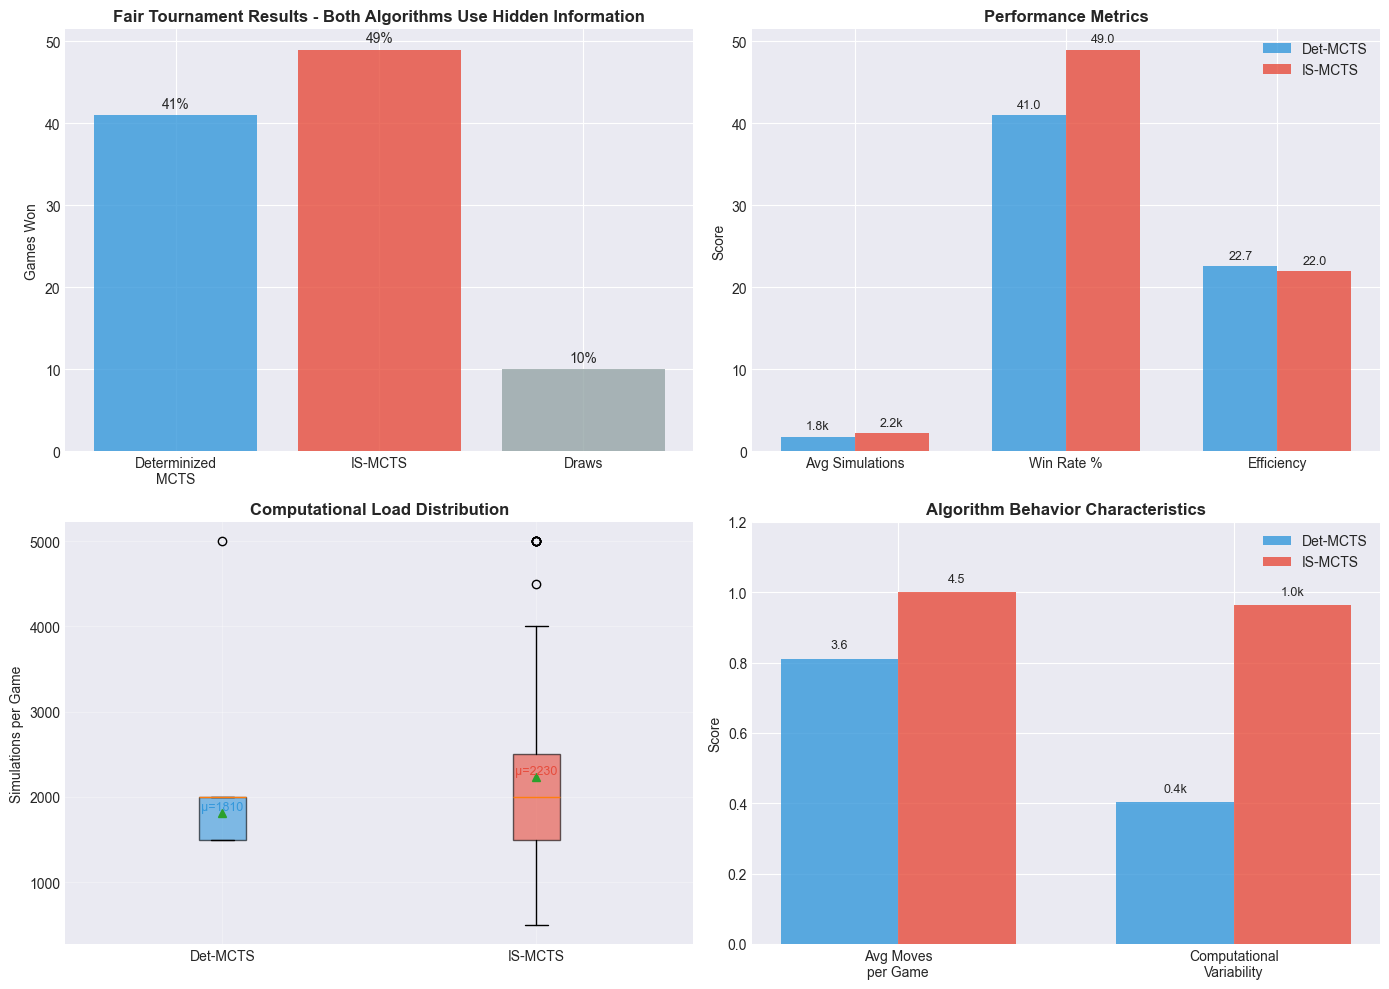



CONCLUSION
Overall improvement: +8% win rate

Seed used: 42


In [19]:
print("Running MCTS vs IS-MCTS tournament for Truco")
GLOBAL_SEED = 42
use_env = USE_REAL_ENV and input("\nUse real TrucoEnvironment? (y/n): ").lower() == 'y'

simulations = 500
print(f"\nRunning tournament with {simulations} simulations per move for both algorithms")
print(f"Using seed {GLOBAL_SEED} for reproducibility")

results = run_fair_tournament(games=100, use_real_env=use_env, simulations_per_move=simulations, seed=GLOBAL_SEED)

print("\n\nTOURNAMENT RESULTS")
print(f"Determinized MCTS Wins: {results['det_mcts_wins']}")
print(f"IS-MCTS Wins: {results['ismcts_wins']}")
print(f"Draws: {results['draws']}")
print(f"\nIS-MCTS Win Rate: {results['ismcts_wins']}%")
print(f"Determinized MCTS Win Rate: {results['det_mcts_wins']}%")

if 'det_mcts_simulations' in results and 'ismcts_simulations' in results:
    avg_det_mcts_sims = np.mean(results['det_mcts_simulations']) if results['det_mcts_simulations'] else 0
    avg_ismcts_sims = np.mean(results['ismcts_simulations']) if results['ismcts_simulations'] else 0
    print(f"\nAverage simulations per game:")
    print(f"  Determinized MCTS: {avg_det_mcts_sims:.0f}")
    print(f"  IS-MCTS: {avg_ismcts_sims:.0f}")
    print(f"\nSimulation ratio (should be ~1.0): {avg_ismcts_sims / avg_det_mcts_sims:.2f}")

fig = visualize_results(results)
plt.savefig('mcts_vs_ismcts_results_500_simulations.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n\nCONCLUSION")
if results['ismcts_wins'] > results['det_mcts_wins']:
    print(f"Overall improvement: +{results['ismcts_wins'] - results['det_mcts_wins']}% win rate")
else:
    print(f"\nWin rate difference: {abs(results['ismcts_wins'] - results['det_mcts_wins'])}%")

print(f"\nSeed used: {GLOBAL_SEED}")